## Import

In [318]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [319]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [320]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [321]:
torch.cuda.is_available()

True

In [322]:
torch.__version__

'2.0.1+cu118'

In [323]:
# torch.cuda.empty_cache()

## Hyperparameter Setting

In [324]:
CFG = {
    'TRAIN_WINDOW_SIZE':120, # 90일치로 학습  초기는 90일이였음 
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [325]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [326]:
train_data = pd.read_csv('E:/LG/LG_data/train.csv').drop(columns = ["ID"])

In [327]:
brand_keyword_cnt = pd.read_csv('E:/LG/LG_data/brand_keyword_cnt.csv')

# EDA

In [328]:
train_data.head(2)

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0


###  <<<<하고 싶은 EDA>>>>

### 먼저 데이터의 분포를 알고 싶은 그래서 대분류 중분류 소분류의 브랜드을 엮을 생각임 
### ex) 대분류, 브랜등 // 대분류 중분류 브랜드 등등 
### 규칙성이 있다면 규칙성이 있는 것 끼리 묶어서 학습을 시키고 싶음

### ==========================================================================

### <<<교수님께 질문 할 것>>>



## 지금 아이디어 


## EDA 일부 해본 결과 이상치를 제거해서 한번 해보는 것이 좋지 않을까 생각중ㅇ이다. 이상치를 제가히면 더 좋지 않을까?? 

In [329]:
train_data.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [330]:
brand_keyword_cnt.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.450530,2.422390,1.871190,1.581080,1.232950,1.174930,1.145920,...,0.319110,0.391640,0.377130,0.49318,0.072520,0.29010,0.31911,0.232080,0.333620,0.44966
1,B002-00002,12.64868,20.27850,15.332170,12.750210,13.562510,13.707570,11.937910,15.564250,14.084710,...,10.269790,11.966920,10.646930,10.41485,10.487380,9.48651,9.28343,10.429350,11.154620,11.38671
2,B002-00003,0.33362,0.43516,0.362630,0.174060,0.217580,0.464170,0.420650,0.290100,0.377130,...,0.536690,0.696250,0.449660,0.39164,1.029880,0.49318,0.91383,0.797790,1.015370,0.88482
3,B002-00005,1.07339,1.71163,2.016240,1.914700,1.987230,2.146790,1.682620,1.378000,1.421520,...,2.219320,2.509420,2.872060,2.37888,2.030750,1.53756,1.34899,1.261960,2.320850,2.30635
4,B002-00006,0.00000,0.00000,0.188558,0.246574,0.246574,0.246574,0.377139,0.087012,0.261084,...,0.072526,0.290103,0.087012,0.00000,0.130542,0.00000,0.00000,0.072526,0.217577,0.00000


In [331]:
sales = pd.read_csv("E:/LG/LG_data/sales.csv")

In [332]:
feature = ["브랜드"]

## 이거 재미있다 배웠다.

In [333]:
import pandas as pd

# sales.csv 파일을 읽어옵니다.
sales = pd.read_csv("E:/LG/LG_data/sales.csv").drop(columns=["ID", '제품', "대분류",
                                                            "중분류", "소분류"])

# 나머지 열의 값을 10000으로 나누어 "sales_divided" 데이터프레임에 저장합니다.
sales_divided = sales.iloc[:, 1:] / 10000

# "브랜드" 열을 추출합니다.
brands = sales["브랜드"]

# "브랜드" 열을 "sales_divided" 데이터프레임의 첫 번째 열로 추가합니다.
sales_divided.insert(0, "브랜드", brands)

# 결과를 확인합니다.
sales_divided.tail()


,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15886,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.069,0.0,4.046,8.092,2.023,2.023,6.069
15887,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15888,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,2.730
15889,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000


In [334]:
sales_divided.tail()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15886,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.069,0.0,4.046,8.092,2.023,2.023,6.069
15887,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15888,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,2.730
15889,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000


C:\Users\User\AppData\Local\Temp\ipykernel_25416\350188470.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\350188470.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\350188470.py:53: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\350188470.py:53: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\350188470.py:53: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\350188470.py:53: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:\Users

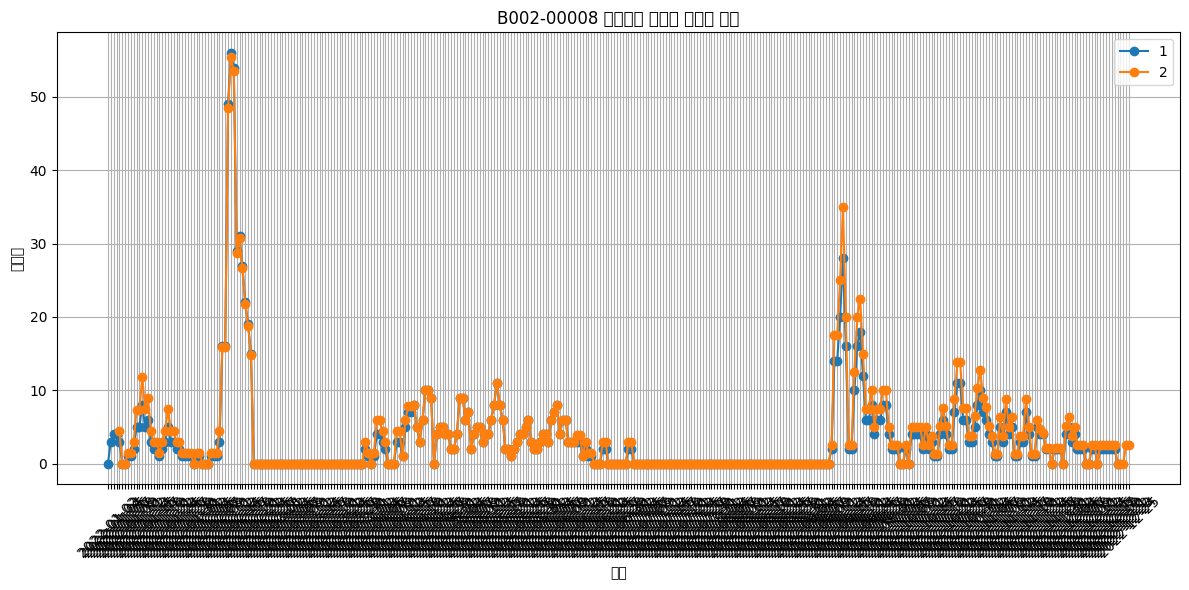

In [335]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463
# 해당 브랜드의 판매량 데이터 추출
# brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
# brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
# brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
# brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]
# brand_sales_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
# & (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
# & (train_data['브랜드'] == 'B002-03463')].iloc[:, 6: 360]


target_brand = 'B002-00008'

# brand_sales_12 = train_data[(train_data['대분류'] == 'B002-C001-0001') 
# & (train_data['중분류'] == 'B002-C002-0001')& (train_data['소분류'] == 'B002-C003-0002') 
# ].iloc[:, 6: 360]
brand_sales_12 = train_data[train_data['브랜드'] == target_brand].iloc[:, 6: 360]

brand_count_sales_12 = sales_divided[sales_divided['브랜드'] == target_brand].iloc[:, 6: 360]



# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
# plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
# plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
# plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
# # plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")
# plt.plot(brand_sales_11.columns, brand_sales_11.values[0], marker='o', linestyle='-', label = "11")
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "1")
plt.plot(brand_count_sales_12.columns, brand_count_sales_12.values[0], marker='o', linestyle='-', label = "2")
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_25416\2027272511.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2027272511.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2027272511.py:53: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2027272511.py:53: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2027272511.py:53: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2027272511.py:53: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:

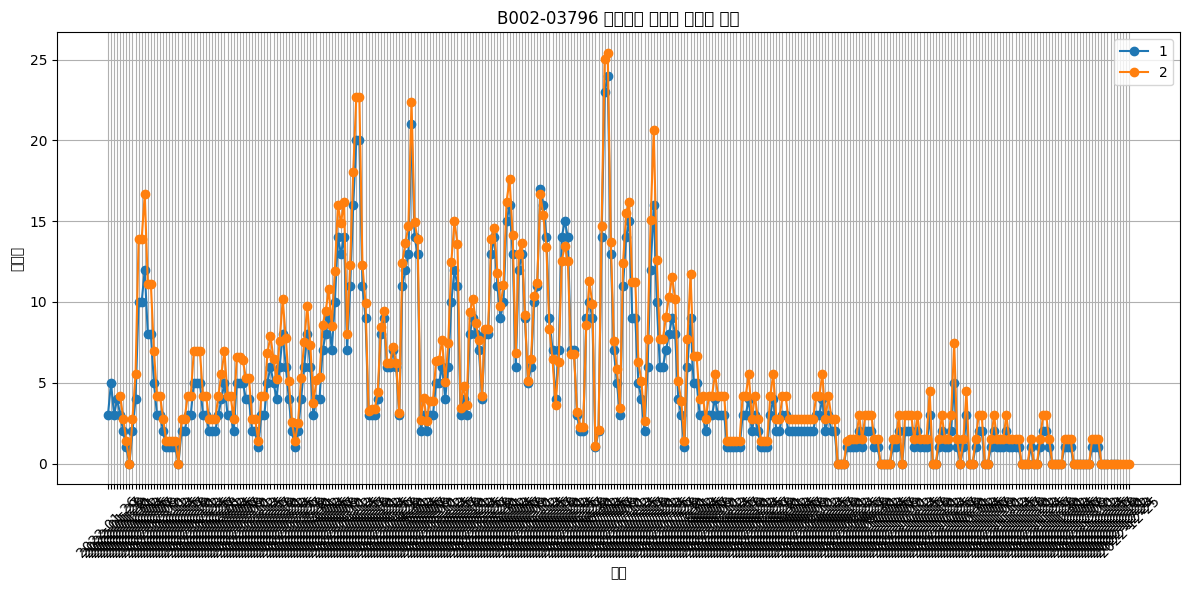

In [336]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463
# 해당 브랜드의 판매량 데이터 추출
# brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
# brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
# brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
# brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]
# brand_sales_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
# & (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
# & (train_data['브랜드'] == 'B002-03463')].iloc[:, 6: 360]


target_brand = 'B002-03796'

# brand_sales_12 = train_data[(train_data['대분류'] == 'B002-C001-0001') 
# & (train_data['중분류'] == 'B002-C002-0001')& (train_data['소분류'] == 'B002-C003-0002') 
# ].iloc[:, 6: 360]
brand_sales_12 = train_data[train_data['브랜드'] == target_brand].iloc[:, 30: 360]

brand_count_sales_12 = sales_divided[sales_divided['브랜드'] == target_brand].iloc[:, 30: 360]



# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
# plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
# plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
# plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
# # plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")
# plt.plot(brand_sales_11.columns, brand_sales_11.values[0], marker='o', linestyle='-', label = "11")
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "1")
plt.plot(brand_count_sales_12.columns, brand_count_sales_12.values[0], marker='o', linestyle='-', label = "2")
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### sales 와 train은 완벽하게 연관성을 갖고 있다 이 두가지 데이터를 잘 이용하면 좋은 결과를 얻을 수 있지 않을까?? 그래서 생각한 것은 둘다 학습을 시키고 그것의 이용하면 좋을꺼 같은데 음......고민된다. 아니먄 이상치라도 다 제거해버려??

이상치를 제거하는 것이 의미가 있을지 모르겠다.. 이 데이터를 보면 이상치 제거가 목적이 아니지 않을까?? 이상치를 잡기보다는 음.... 규칙성을 잘 잡을 수 있게 학습을 하는 것이 더욱 좋을 것이라고 보여진다.

## train and brand key word 시각화

In [337]:
brand_keyword_cnts = pd.read_csv("E:/LG/LG_data/brand_keyword_cnt.csv")

brand_keyword_cntss = brand_keyword_cnts.iloc[:,1: :] * 3

brand = brand_keyword_cnts["브랜드"]

brand_keyword_cntss.insert(0, "브랜드", brand)

brand_keyword_cntss.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,2.52393,2.74149,4.351590,7.267170,5.613570,4.743240,3.698850,3.524790,3.437760,...,0.957330,1.17492,1.131390,1.47954,0.217560,0.87030,0.95733,0.696240,1.000860,1.34898
1,B002-00002,37.94604,60.83550,45.996510,38.250630,40.687530,41.122710,35.813730,46.692750,42.254130,...,30.809370,35.90076,31.940790,31.24455,31.462140,28.45953,27.85029,31.288050,33.463860,34.16013
2,B002-00003,1.00086,1.30548,1.087890,0.522180,0.652740,1.392510,1.261950,0.870300,1.131390,...,1.610070,2.08875,1.348980,1.17492,3.089640,1.47954,2.74149,2.393370,3.046110,2.65446
3,B002-00005,3.22017,5.13489,6.048720,5.744100,5.961690,6.440370,5.047860,4.134000,4.264560,...,6.657960,7.52826,8.616180,7.13664,6.092250,4.61268,4.04697,3.785880,6.962550,6.91905
4,B002-00006,0.00000,0.00000,0.565673,0.739721,0.739721,0.739721,1.131417,0.261037,0.783251,...,0.217577,0.87031,0.261037,0.00000,0.391625,0.00000,0.00000,0.217577,0.652732,0.00000


C:\Users\User\AppData\Local\Temp\ipykernel_25416\484092198.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\484092198.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\484092198.py:53: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\484092198.py:53: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\484092198.py:53: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\484092198.py:53: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:\Users

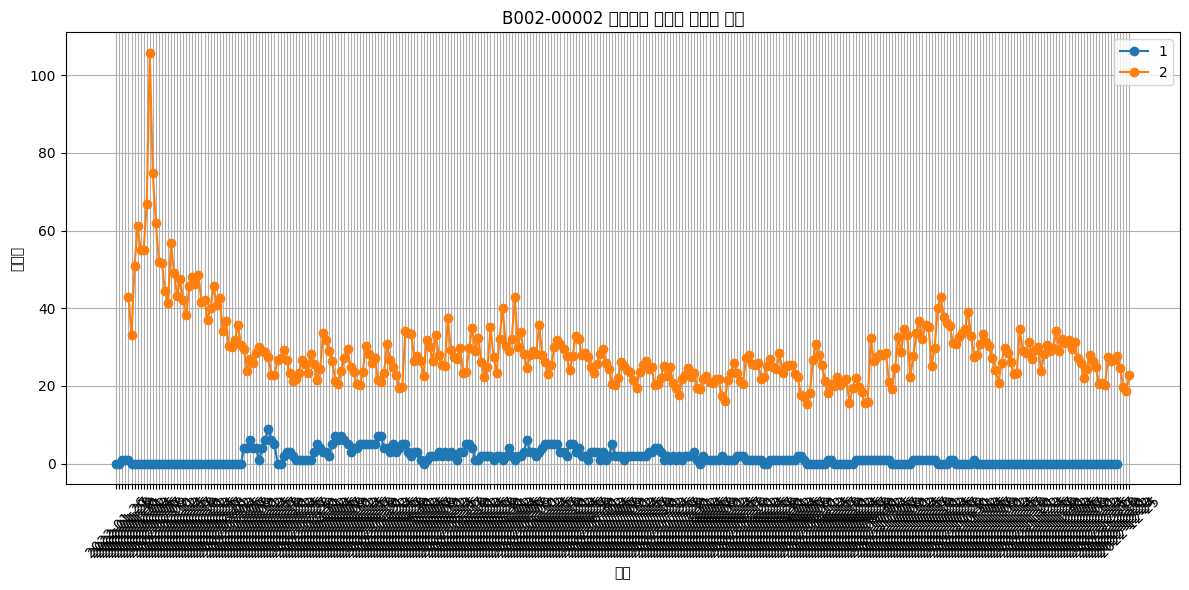

In [338]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463
# 해당 브랜드의 판매량 데이터 추출
# brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
# brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
# brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
# brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]
# brand_sales_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
# & (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
# & (train_data['브랜드'] == 'B002-03463')].iloc[:, 6: 360]


target_brand = 'B002-00002'

# brand_sales_12 = train_data[(train_data['대분류'] == 'B002-C001-0001') 
# & (train_data['중분류'] == 'B002-C002-0001')& (train_data['소분류'] == 'B002-C003-0002') 
# ].iloc[:, 6: 360]
brand_sales_12 = train_data[train_data['브랜드'] == target_brand].iloc[:, 30: 360]

brand_count_sales_12 = brand_keyword_cntss[brand_keyword_cntss['브랜드'] == target_brand].iloc[:, 30: 360]



# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
# plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
# plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
# plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
# # plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")
# plt.plot(brand_sales_11.columns, brand_sales_11.values[0], marker='o', linestyle='-', label = "11")
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "1")
plt.plot(brand_count_sales_12.columns, brand_count_sales_12.values[0], marker='o', linestyle='-', label = "2")
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## train과  key_word_count연관성이 딱히 없음

C:\Users\User\AppData\Local\Temp\ipykernel_25416\855693185.py:54: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\855693185.py:54: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\855693185.py:54: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\855693185.py:54: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\855693185.py:54: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\855693185.py:54: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:\Users

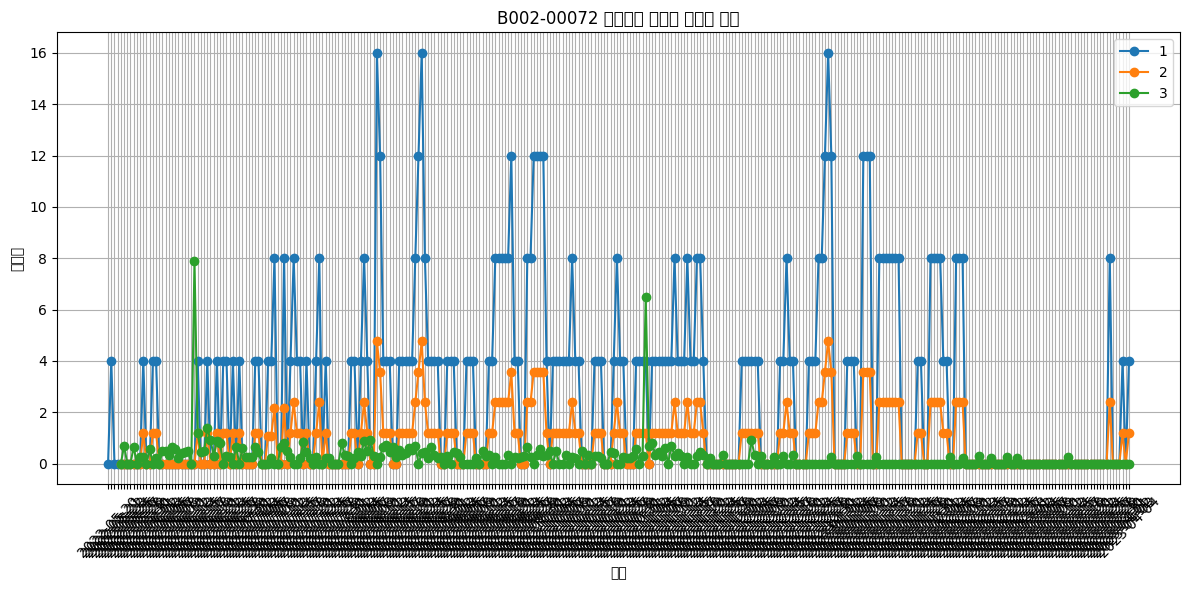

In [339]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463
# 해당 브랜드의 판매량 데이터 추출
# brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
# brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
# brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
# brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]
# brand_sales_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
# & (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
# & (train_data['브랜드'] == 'B002-03463')].iloc[:, 6: 360]


target_brand = 'B002-00072'

# brand_sales_12 = train_data[(train_data['대분류'] == 'B002-C001-0001') 
# & (train_data['중분류'] == 'B002-C002-0001')& (train_data['소분류'] == 'B002-C003-0002') 
# ].iloc[:, 6: 360]
brand_sales_12 = train_data[train_data['브랜드'] == target_brand].iloc[:, 144: 464]

sales_divided_sales_12 = sales_divided[sales_divided['브랜드'] == target_brand].iloc[:, 144: 464]

brand_keyword_cntss_sales_12 = brand_keyword_cntss[brand_keyword_cntss['브랜드'] == target_brand].iloc[:, 144: 464]

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
# plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
# plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
# plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
# # plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")
# plt.plot(brand_sales_11.columns, brand_sales_11.values[0], marker='o', linestyle='-', label = "11")
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "1")
plt.plot(sales_divided_sales_12.columns, sales_divided_sales_12.values[0], marker='o', linestyle='-', label = "2")
plt.plot(brand_keyword_cntss_sales_12.columns, brand_keyword_cntss_sales_12.values[0], marker='o', linestyle='-', label = "3")
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_25416\4051359543.py:135: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\4051359543.py:135: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\4051359543.py:135: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\4051359543.py:135: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\4051359543.py:135: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\4051359543.py:135: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layou

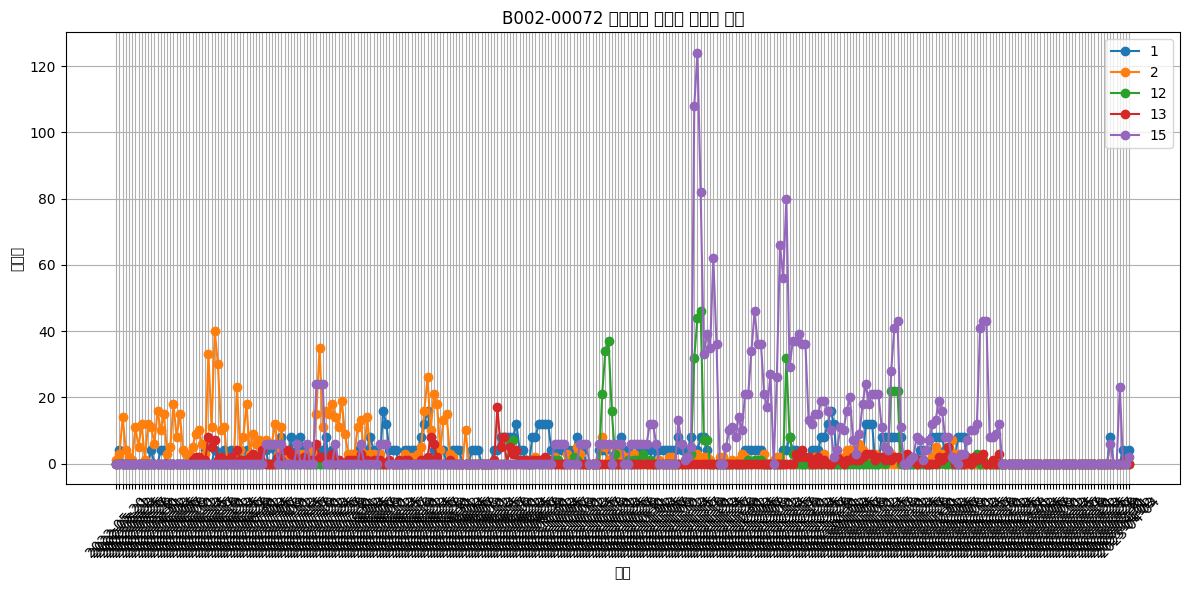

In [341]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463
# 해당 브랜드의 판매량 데이터 추출
# brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
# brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
# brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
# brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]
# brand_sales_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
# & (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
# & (train_data['브랜드'] == 'B002-03463')].iloc[:, 6: 360]


# 5104  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03448      1
# 5105  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463     15
# 5106  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03476      8
# 5107  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03528      4
# 5108  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03709      2




#     B002-C001-0001  B002-C002-0001  B002-C003-0001    751
# 1   B002-C001-0001  B002-C002-0001  B002-C003-0002    663
# 2   B002-C001-0001  B002-C002-0001  B002-C003-0003   1426
# 3   B002-C001-0001  B002-C002-0001  B002-C003-0004    426
# 4   B002-C001-0001  B002-C002-0001  B002-C003-0005    342
# 5   B002-C001-0001  B002-C002-0009  B002-C003-0051    160
# 6   B002-C001-0002  B002-C002-0002  B002-C003-0006    175
# 7   B002-C001-0002  B002-C002-0002  B002-C003-0007    262
# 8   B002-C001-0002  B002-C002-0002  B002-C003-0008    112
# 9   B002-C001-0002  B002-C002-0002  B002-C003-0009    183
# 10  B002-C001-0002  B002-C002-0002  B002-C003-0010    113
# 11  B002-C001-0002  B002-C002-0002  B002-C003-0011    101


# 0   B002-C001-0001  B002-C002-0001   3608
# 1   B002-C001-0001  B002-C002-0009    160
# 2   B002-C001-0002  B002-C002-0002    946
# 3   B002-C001-0002  B002-C002-0003   1516
# 4   B002-C001-0002  B002-C002-0004   1168
# 5   B002-C001-0002  B002-C002-0005   2275
# 6   B002-C001-0002  B002-C002-0006   1675
# 7   B002-C001-0002  B002-C002-0007   2501
# 8   B002-C001-0002  B002-C002-0009    873
# 9   B002-C001-0003  B002-C002-0008    410
# 10  B002-C001-0003  B002-C002-0010     34
# 11  B002-C001-0004  B002-C002-0009    111
# 12  B002-C001-0005  B002-C002-0011    613



# target_brand = 'B002-00072'

# brand_sales_12 = train_data[(train_data['대분류'] == 'B002-C001-0001') 
# & (train_data['중분류'] == 'B002-C002-0001')& (train_data['소분류'] == 'B002-C003-0002') 
# ].iloc[:, 6: 360]
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03448 

brand_sales_12s = train_data[(train_data['제품'] == 'B002-03463-00008') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03448')].iloc[:, 144: 464]


sales_divided_11 = train_data[(train_data['제품'] == 'B002-03463-00009') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03463')].iloc[:, 144: 464]

sales_divided_15 = train_data[(train_data['제품'] == 'B002-03463-00015') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03463')].iloc[:, 144: 464]


sales_divided_12 = train_data[(train_data['제품'] == 'B002-03463-00012') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03463')].iloc[:, 144: 464]


sales_divided_13 = train_data[(train_data['제품'] == 'B002-03463-00013') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03463')].iloc[:, 144: 464]





# brand_sales_12 = train_data[train_data['브랜드'] == target_brand].iloc[:, 144: 464]

# sales_divided_sales_12 = sales_divided[sales_divided['브랜드'] == target_brand].iloc[:, 144: 464]

# brand_keyword_cntss_sales_12 = brand_keyword_cntss[brand_keyword_cntss['브랜드'] == target_brand].iloc[:, 144: 464]

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
# plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
# plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
# plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
# # plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")
# plt.plot(brand_sales_11.columns, brand_sales_11.values[0], marker='o', linestyle='-', label = "11")
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "1")
plt.plot(sales_divided_11.columns, sales_divided_11.values[0], marker='o', linestyle='-', label = "2")
plt.plot(sales_divided_12.columns, sales_divided_12.values[0], marker='o', linestyle='-', label = "12")
plt.plot(sales_divided_13.columns, sales_divided_13.values[0], marker='o', linestyle='-', label = "13")
plt.plot(sales_divided_15.columns, sales_divided_15.values[0], marker='o', linestyle='-', label = "15")

plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 하나만 본거지만 대분류, 중분류, 소분류, 브랜드를 통해서 같은 체널에서 같은 브랜드의 제품을 팔았을때 판매량이 감소하는 경향성이 있음 // 즉 제품은 다르지만 경향성 측면에서는 존재하는 것 같다.  // <가설> 감소하는 이유는 아마도 해 당 채널의 광고가 감소또는 그 채널의 기능이 점차 약해지는 것이 아닐지 유추 해본다.

C:\Users\User\AppData\Local\Temp\ipykernel_25416\2124064529.py:128: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2124064529.py:128: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2124064529.py:128: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2124064529.py:128: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2124064529.py:128: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\2124064529.py:128: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layou

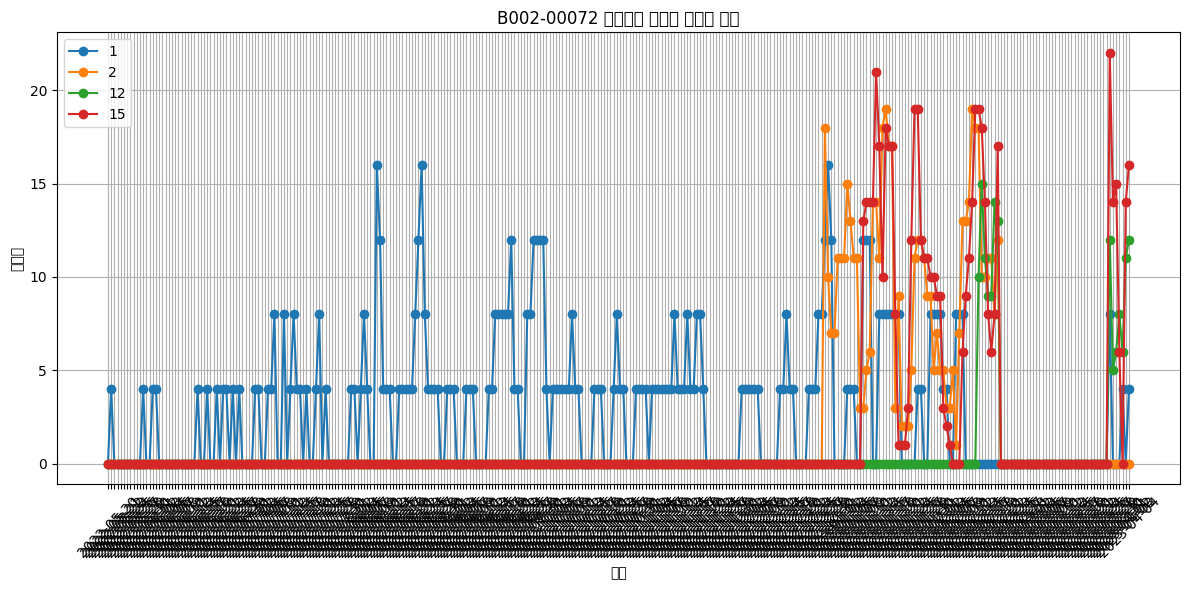

In [346]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463
# 해당 브랜드의 판매량 데이터 추출
# brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
# brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
# brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
# brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]
# brand_sales_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
# & (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
# & (train_data['브랜드'] == 'B002-03463')].iloc[:, 6: 360]


# 5104  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03448      1
# 5105  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03463     15
# 5106  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03476      8
# 5107  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03528      4
# 5108  B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03709      2




#     B002-C001-0001  B002-C002-0001  B002-C003-0001    751
# 1   B002-C001-0001  B002-C002-0001  B002-C003-0002    663
# 2   B002-C001-0001  B002-C002-0001  B002-C003-0003   1426
# 3   B002-C001-0001  B002-C002-0001  B002-C003-0004    426
# 4   B002-C001-0001  B002-C002-0001  B002-C003-0005    342
# 5   B002-C001-0001  B002-C002-0009  B002-C003-0051    160
# 6   B002-C001-0002  B002-C002-0002  B002-C003-0006    175
# 7   B002-C001-0002  B002-C002-0002  B002-C003-0007    262
# 8   B002-C001-0002  B002-C002-0002  B002-C003-0008    112
# 9   B002-C001-0002  B002-C002-0002  B002-C003-0009    183
# 10  B002-C001-0002  B002-C002-0002  B002-C003-0010    113
# 11  B002-C001-0002  B002-C002-0002  B002-C003-0011    101


# 0   B002-C001-0001  B002-C002-0001   3608
# 1   B002-C001-0001  B002-C002-0009    160
# 2   B002-C001-0002  B002-C002-0002    946
# 3   B002-C001-0002  B002-C002-0003   1516
# 4   B002-C001-0002  B002-C002-0004   1168
# 5   B002-C001-0002  B002-C002-0005   2275
# 6   B002-C001-0002  B002-C002-0006   1675
# 7   B002-C001-0002  B002-C002-0007   2501
# 8   B002-C001-0002  B002-C002-0009    873
# 9   B002-C001-0003  B002-C002-0008    410
# 10  B002-C001-0003  B002-C002-0010     34
# 11  B002-C001-0004  B002-C002-0009    111
# 12  B002-C001-0005  B002-C002-0011    613



# target_brand = 'B002-00072'

# brand_sales_12 = train_data[(train_data['대분류'] == 'B002-C001-0001') 
# & (train_data['중분류'] == 'B002-C002-0001')& (train_data['소분류'] == 'B002-C003-0002') 
# ].iloc[:, 6: 360]
# B002-C001-0005  B002-C002-0011  B002-C003-0053  B002-03448 

brand_sales_12s = train_data[(train_data['제품'] == 'B002-03528-00004') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03528')].iloc[:, 144: 464]


sales_divided_11 = train_data[(train_data['제품'] == 'B002-03528-00010') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03528')].iloc[:, 144: 464]

sales_divided_15 = train_data[(train_data['제품'] == 'B002-03528-00012') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03528')].iloc[:, 144: 464]


sales_divided_12 = train_data[(train_data['제품'] == 'B002-03528-00013') 
                            & (train_data['대분류'] == 'B002-C001-0005') 
                            & (train_data['중분류'] == 'B002-C002-0011')
                            & (train_data['소분류'] == 'B002-C003-0053') 
                            & (train_data['브랜드'] == 'B002-03528')].iloc[:, 144: 464]






# brand_sales_12 = train_data[train_data['브랜드'] == target_brand].iloc[:, 144: 464]

# sales_divided_sales_12 = sales_divided[sales_divided['브랜드'] == target_brand].iloc[:, 144: 464]

# brand_keyword_cntss_sales_12 = brand_keyword_cntss[brand_keyword_cntss['브랜드'] == target_brand].iloc[:, 144: 464]

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
# plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
# plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
# plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
# # plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")
# plt.plot(brand_sales_11.columns, brand_sales_11.values[0], marker='o', linestyle='-', label = "11")
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "1")
plt.plot(sales_divided_11.columns, sales_divided_11.values[0], marker='o', linestyle='-', label = "2")
plt.plot(sales_divided_12.columns, sales_divided_12.values[0], marker='o', linestyle='-', label = "12")
plt.plot(sales_divided_15.columns, sales_divided_15.values[0], marker='o', linestyle='-', label = "15")

plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 확실히 같은 채녈 , 같은브랜드는 연관성이 있다!!! 물론 전부는 아니지만 묶어서 학습하면 좋을 듯 // 제품에 따라서 일부 차이가 있지만 판매량이 제로인 시기만 봐도 그 채널 또는 브랜드가 일시적 죽는 현상을 확인 가능

In [355]:
train_data.describe()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,15890.000000,15890.000000,15890.00000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,12.887476,10.418880,9.01309,9.190938,11.204216,12.486281,12.933103,12.832599,13.326935,12.049843,...,0.501699,0.483260,0.473694,9.498175,9.370044,7.706293,7.123033,6.975456,9.040340,10.031026
std,183.612376,149.663362,95.82452,86.274138,92.072773,108.478567,135.615709,233.900622,242.761978,242.326264,...,8.853648,8.911203,8.567765,93.854552,90.632349,68.413621,68.629350,59.826757,73.637191,103.256072
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,15056.000000,14320.000000,6064.00000,4470.000000,6370.000000,8210.000000,9712.000000,24512.000000,24032.000000,24960.000000,...,700.000000,660.000000,660.000000,4308.000000,4596.000000,3960.000000,4224.000000,2700.000000,3045.000000,6048.000000


In [356]:
filtered_data.describe()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,14997.00000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,...,14997.000000,14997.000000,14997.000000,14997.000000,14997.00000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000
mean,3.75195,3.203974,3.146229,3.401547,4.450357,4.926252,4.933253,4.216577,4.047810,3.683803,...,0.127492,0.123825,0.130359,2.880176,2.88171,2.563513,2.406481,2.320064,3.121291,3.378476
std,15.88018,13.176483,12.678100,13.017592,16.775112,18.163946,18.311198,16.480034,16.081134,14.713084,...,1.156304,1.131140,1.146397,11.290213,11.45781,9.954266,9.865710,9.040408,11.911384,12.881790
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,480.00000,252.000000,253.000000,247.000000,281.000000,304.000000,353.000000,524.000000,523.000000,518.000000,...,26.000000,26.000000,26.000000,270.000000,239.00000,200.000000,210.000000,180.000000,210.000000,240.000000


In [380]:
import pandas as pd
import numpy as np

# 데이터 파일 불러오기
data = data # 'data.csv'를 실제 파일 경로로 바꾸세요.

# 이상치 제거 함수 정의 (행마다 계산)
def remove_outliers(data, threshold=10):
    z_scores = np.abs(data - data.mean(axis=1) / data.std(axis=1))
    filtered_data = data[(z_scores < threshold).all(axis=1)]
    return filtered_data

# 이상치 제거 적용
filtered_data = remove_outliers(data.select_dtypes(include='number'))

# 결과를 확인합니다.
filtered_data.shape


(0, 459)

In [408]:
import pandas as pd
import numpy as np

# 데이터 파일 불러오기
data = train_data  # 'data.csv'를 실제 파일 경로로 바꾸세요.

# 숫자 열만 선택
numeric_columns = data.select_dtypes(include='number')

# 각 행의 숫자 평균 값을 계산합니다.
row_means = numeric_columns.mean(axis=1)

# 0을 해당 행의 평균 값으로 바꿉니다.
for col in numeric_columns.columns:
    data[col] = np.where(data[col] == 0, row_means, data[col])

# 결과를 확인합니다.
data.to_csv("E:/LG/LG_data/datassssss.csv")

datassssss = pd.read_csv("E:/LG/LG_data/datassssss.csv")

In [409]:
datassssss = pd.read_csv("E:/LG/LG_data/datassssss.csv")

In [416]:
import pandas as pd
import numpy as np

# 데이터 파일 불러오기
datas = datassssss  # 'data.csv'를 실제 파일 경로로 바꾸세요.

# 이상치 제거 함수 정의
def remove_outliers(datas, threshold=100):
    z_scores = np.abs((datas - datas.mean()) / datas.std())
    filtered_data = datas[(z_scores < threshold).all(axis=1)]
    return filtered_data

# 이상치 제거 적용
filtered_data = remove_outliers(datas.select_dtypes(include='number'))

# 결과를 확인합니다.

filtered_data.shape

(15884, 460)

In [417]:
filtered_data.head()

,Unnamed: 0,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,...,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277
1,1,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,...,1.281046,1.281046,1.281046,1.000000,3.000000,2.000000,1.281046,1.281046,2.000000,1.281046
2,2,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,...,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259
3,3,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,...,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695
4,4,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,...,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845


In [418]:
brand = train_data["브랜드"]
filtered_data.insert(1, "브랜드", brand)
filtered_data.head()

,Unnamed: 0,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,...,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277,0.747277
1,1,B002-00002,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,1.281046,...,1.281046,1.281046,1.281046,1.000000,3.000000,2.000000,1.281046,1.281046,2.000000,1.281046
2,2,B002-00002,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,...,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259,2.259259
3,3,B002-00002,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,...,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695,3.459695
4,4,B002-00003,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,...,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845,2.668845


In [426]:
train_datas.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [397]:
filtered_data.describe()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,...,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000,14042.000000
mean,4.144480,3.840740,3.804959,3.972969,4.527218,4.819300,4.849150,4.447385,4.267705,4.073808,...,3.586328,3.571733,3.575117,3.959624,3.918249,3.774755,3.669726,3.626977,4.050873,4.218238
std,8.756277,7.915446,7.661609,8.165352,9.562597,10.434238,10.576024,9.923219,9.366928,8.952274,...,6.792523,6.723763,6.714918,7.735176,7.738174,7.239062,6.978956,6.919667,7.856265,8.442264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.215686,0.215686,0.215686,0.216231,0.217865,0.222222,0.222222,0.220044,0.217865,0.217865,...,0.206972,0.206972,0.209150,0.222222,0.222222,0.218410,0.220044,0.217865,0.237473,0.239651
50%,1.031590,1.010893,1.010893,1.010893,1.053377,1.084967,1.094771,1.044662,1.026144,1.010893,...,1.041394,1.037037,1.045752,1.084967,1.064270,1.045752,1.045752,1.052288,1.117647,1.148148
75%,4.000000,3.921569,3.956427,4.000000,4.077887,4.462963,4.483660,4.000000,4.000000,4.000000,...,3.711874,3.707516,3.718954,4.000000,4.000000,4.000000,3.947168,3.881264,4.000000,4.027778
max,150.000000,138.000000,110.000000,116.000000,123.000000,142.000000,165.000000,257.000000,241.000000,260.000000,...,88.917211,88.917211,88.917211,117.000000,117.000000,94.000000,96.000000,88.917211,104.000000,135.000000


In [361]:
train_data.describe()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,15890.000000,15890.000000,15890.00000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,12.887476,10.418880,9.01309,9.190938,11.204216,12.486281,12.933103,12.832599,13.326935,12.049843,...,0.501699,0.483260,0.473694,9.498175,9.370044,7.706293,7.123033,6.975456,9.040340,10.031026
std,183.612376,149.663362,95.82452,86.274138,92.072773,108.478567,135.615709,233.900622,242.761978,242.326264,...,8.853648,8.911203,8.567765,93.854552,90.632349,68.413621,68.629350,59.826757,73.637191,103.256072
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,15056.000000,14320.000000,6064.00000,4470.000000,6370.000000,8210.000000,9712.000000,24512.000000,24032.000000,24960.000000,...,700.000000,660.000000,660.000000,4308.000000,4596.000000,3960.000000,4224.000000,2700.000000,3045.000000,6048.000000


In [424]:
train_datas = pd.read_csv('E:/LG/LG_data/train.csv').drop(columns = ["ID"])

C:\Users\User\AppData\Local\Temp\ipykernel_25416\1966666397.py:26: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\1966666397.py:26: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\1966666397.py:26: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\1966666397.py:26: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\1966666397.py:26: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25416\1966666397.py:26: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:

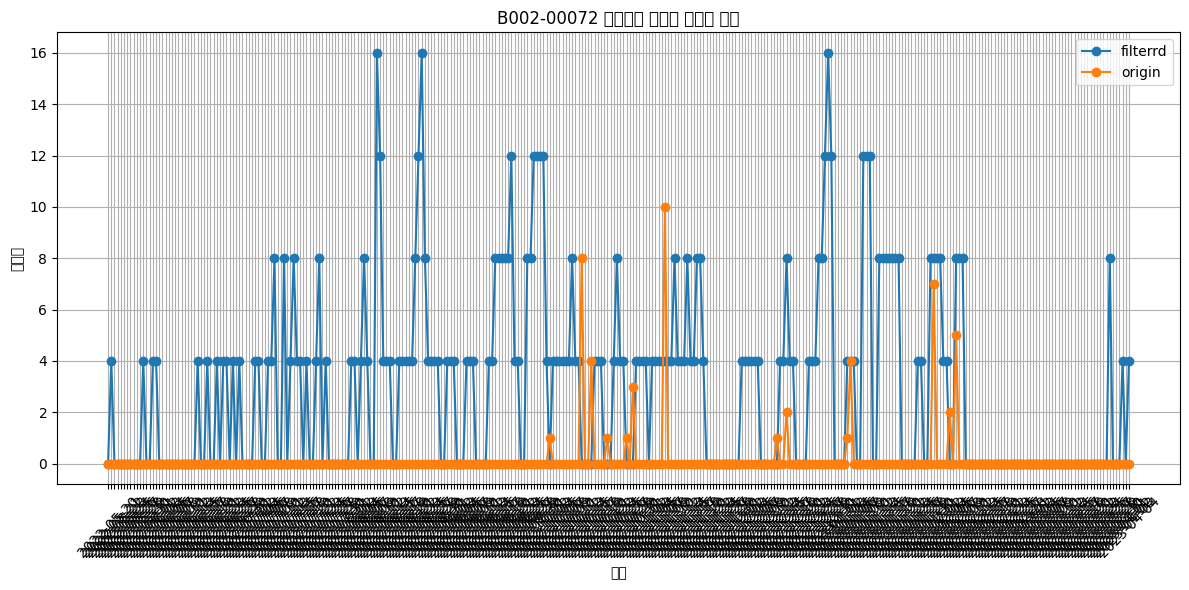

In [430]:
import pandas as pd
import matplotlib.pyplot as plt


brand_sales_12s = filtered_data[filtered_data['브랜드'] == 'B002-00005'].iloc[:, 144: 464]


sales_divided_11 = train_datas[train_datas['브랜드'] == 'B002-00005'].iloc[:, 144: 464]


# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales_12.columns, brand_sales_12.values[0], marker='o', linestyle='-', label = "filterrd")
plt.plot(sales_divided_11.columns, sales_divided_11.values[0], marker='o', linestyle='-', label = "origin")
# 

plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## resent // 1d 2d 차이 2d도 시계열에 사용가능한지 // 그룹화 해서 학습시키는 것

## <궁금한것 생김>

## 이 데이터 22년 1월 1일 부터 120 일 치 분석일지 4월4일 - 120 분석일까 나는 후자가 무조건 맞다고 보거든 아닐수도 있을니까 찾자 -> 찾아 본 결과 후자로 학습을 진행함 

## ========================================================================

# 9월 10일 : EDA 연구 // 가설 가능성 정리해보자 //

In [275]:
section =train_data[train_data['브랜드'] == 'B002-00028']
section.head()

sales_divided_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
& (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
& (train_data['브랜드'] == 'B002-03463')]


,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
57,B002-00028-00001,B002-C001-0002,B002-C002-0003,B002-C003-0016,B002-00028,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
sales_divided_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
& (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
& (train_data['브랜드'] == 'B002-03463')]


sales_divided_11.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
14676,B002-03463-00008,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,1,...,0,0,0,0,0,0,2,0,2,0
14677,B002-03463-00009,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14678,B002-03463-00012,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14679,B002-03463-00013,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14680,B002-03463-00015,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,6,0,0,23,0,0,2


In [342]:

sales_divided_22 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
& (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
& (train_data['브랜드'] == 'B002-03528')]


sales_divided_22.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
14884,B002-03528-00004,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,16,8,12,12,9,18,5
14885,B002-03528-00010,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14886,B002-03528-00012,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,22,14,15,6,0,14,16
14887,B002-03528-00013,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,12,5,6,8,6,11,12


## 이상치 제거

### <구상>

### 우선 0을 제외한 숫자의 합의 평균을 구하고 그리고 표준편차를 구해서 빼고 이상치는 그 전 값으로 바꾸기

In [101]:
train_data.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# import pandas as pd


# # 2 sigma 이상치 제거 함수 정의

# numeric = train_data.columns[5:]

# # 칵 column의 min 및 max 계산
# mean_values = train_data[numeric].mean(axis=1)
# std_values = train_data[numeric].std(axis=1)


# lower = mean_values - std_values*2
# upper = mean_values + std_values*2


# print(lower)
# print(upper)


# outliers = train_data[numeric].between(lower, upper)(axis =1)





In [186]:
import pandas as pd

# 2 sigma 이상치 제거 함수 정의

numeric = train_data.columns[5:]

# 칵 column의 min 및 max 계산
mean_values = train_data[numeric].mean(axis=1)
std_values = train_data[numeric].std(axis=1)

lower = mean_values - std_values * 2
upper = mean_values + std_values * 2




In [185]:
import pandas as pd

# 2 sigma 이상치 제거 함수 정의

numeric = train_data.columns[5:]

# 칵 column의 min 및 max 계산
mean_values = train_data[numeric].mean(axis=1)
std_values = train_data[numeric].std(axis=1)

lower = mean_values - std_values * 2
upper = mean_values + std_values * 2

# # 이상치(outliers)를 탐지
# outliers = train_data[numeric].apply(lambda row: (row < lower) | (row > upper), axis=1)

# # 인덱스를 재설정하여 이상치에 해당하는 값을 직전 값으로 대체
# for i, row in enumerate(outliers):
#     if row.any():
#         row = row.reset_index(drop=True)  # 인덱스 재설정
#         for j, is_outlier in enumerate(row):
#             if is_outlier:
#                 if j > 0:
#                     train_data.loc[i, numeric[j]] = train_data.loc[i, numeric[j-1]]
#                 else:
#                     train_data.loc[i, numeric[j]] = mean_values[i]


In [ ]:
# # 2 sigma 이상치 제거 함수 정의
# def remove_outliers_sigma(df, row_name):

#   values = row_name

#   # 평균값 +- 표준편자 * 2
#   lower = df[column_name].mean() - (df[column_name].std() *2)
#   upper = df[column_name].mean() + (df[column_name].std() *2)

#   # min ~ max 안에 포함되는 데이터만 저장
#   removed_outliers = df[column_name].between(lower, upper)

#   # 기존 데이터 사이즈와 이상치 제거 후 데이터 사이즈 비교
#   bf  = df[column_name].size
#   print(str(df[column_name][removed_outliers].size) + "/" + str(bf) + " data points remain.")

#   # 전체 데이터에서 이상치에 해당하는 값만 임시저장
#   index_names = df[~removed_outliers].index

#   # 이상치 인덱스를 제거한 데이터프레임 반환
#   return df.drop(index_names)

In [208]:
brand_keyword_cnt.head(2)

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671


### 데이터 전처리

In [233]:
import pandas as pd

# 더 작은 값을 추가하여 분모가 0인 경우 방지하는 상수 정의
EPSILON = 1e-8

numeric_cols = train_data.columns[5:]

# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)

max_values = train_data[numeric_cols].max(axis=1)


# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 EPSILON 더해주기
ranges = max_values - min_values + EPSILON

# min-max scaling 수행
scaled_data = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)

# 스케일링된 데이터로 업데이트
train_data[numeric_cols] = scaled_data

# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15885    0.0
15886    0.0
15887    0.0
15888    0.0
15889    0.0
Length: 15890, dtype: float64
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
15885    1.0
15886    1.0
15887    1.0
15888    1.0
15889    1.0
Length: 15890, dtype: float64


In [175]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ["제품",'대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [176]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :5]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, 5:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [177]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :5]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [178]:
train_data.tail()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,15835,2,7,41,3169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000
15886,15836,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02439,0.0,0.01626,0.03252,0.00813,0.00813,0.024390
15887,15837,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000
15888,15838,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.142857
15889,15839,1,3,19,3169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000


In [179]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

100%|██████████| 15890/15890 [00:19<00:00, 809.34it/s]


In [183]:
print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(len(train_input))
print(len(train_data))

(4633524, 120, 6)
(15890, 120, 6)
(4633524, 21)
4633524
15890


In [170]:
# data_len = len(train_input)
# val_ratio = 0.1
# test_ratio = 0.1

# val_len = int(data_len * val_ratio)
# test_len = int(data_len * test_ratio)

# val_input = train_input[-val_len:]
# val_target = train_target[-val_len:]

# train_input = train_input[:-val_len - test_len]
# train_target = train_target[:-val_len - test_len]


In [181]:
data_len = len(train_input)
val_ratio = 0.1

val_len = int(data_len * val_ratio)

val_input = train_input[-val_len:]
val_target = train_target[-val_len:]

train_input = train_input[:-val_len]
train_target = train_target[:-val_len]


In [182]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4633524, 120, 6),
 (4633524, 21),
 (514836, 120, 6),
 (514836, 21),
 (15890, 120, 6))

### Custom Dataset

In [222]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [223]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 모델 선언

# Layer Normalization

In [224]:
class ImprovedModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, num_layers=2, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2):
        super(ImprovedModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.ln = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        gru_out, hidden = self.gru(x, hidden)
        gru_out = self.dropout(gru_out)
        gru_out = self.ln(gru_out)  # Applying Layer Normalization

        last_output = gru_out[:, -1, :]

        output = self.actv(self.fc(last_output))

        return output.squeeze(1)
    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)



### 모델 학습

In [225]:
def train(model, optimizer, train_loader, val_loader, device, scheduler=None):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    max_early_stopping = 10  # Max number of consecutive epochs with increasing validation loss
    
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        train_mae = []

        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())


        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(val_loss)  # Update learning rate based on scheduler's policy
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= max_early_stopping:
                print(f'Early stopping triggered at epoch {epoch}')
                break

    return best_model


In [226]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [37]:
import torch.optim.lr_scheduler as lr_scheduler

model = ImprovedModel() # BaseModel() 
optimizer = torch.optim.RAdam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.7, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, device, scheduler)


100%|██████████| 126/126 [00:28<00:00,  4.44it/s]


Epoch : [1] Train Loss : [0.03244] Val Loss : [0.02965]


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Epoch : [2] Train Loss : [0.03041] Val Loss : [0.03081]


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [3] Train Loss : [0.02909] Val Loss : [0.02969]
Epoch 00003: reducing learning rate of group 0 to 7.0000e-05.


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [4] Train Loss : [0.02816] Val Loss : [0.02954]


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [5] Train Loss : [0.02770] Val Loss : [0.03008]


100%|██████████| 126/126 [00:27<00:00,  4.50it/s]


Epoch : [6] Train Loss : [0.02476] Val Loss : [0.01791]


100%|██████████| 126/126 [00:27<00:00,  4.52it/s]


Epoch : [7] Train Loss : [0.01737] Val Loss : [0.01757]


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


Epoch : [8] Train Loss : [0.01701] Val Loss : [0.01704]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [9] Train Loss : [0.01697] Val Loss : [0.01661]


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


Epoch : [10] Train Loss : [0.01682] Val Loss : [0.01810]


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


Epoch : [11] Train Loss : [0.01676] Val Loss : [0.01643]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [12] Train Loss : [0.01646] Val Loss : [0.01679]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [13] Train Loss : [0.01638] Val Loss : [0.01614]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [14] Train Loss : [0.01637] Val Loss : [0.01640]


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


Epoch : [15] Train Loss : [0.01632] Val Loss : [0.01612]


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Epoch : [16] Train Loss : [0.01625] Val Loss : [0.01610]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [17] Train Loss : [0.01623] Val Loss : [0.01657]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [18] Train Loss : [0.01619] Val Loss : [0.01629]
Epoch 00018: reducing learning rate of group 0 to 4.9000e-05.


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch : [19] Train Loss : [0.01606] Val Loss : [0.01621]


100%|██████████| 126/126 [00:27<00:00,  4.65it/s]


Epoch : [20] Train Loss : [0.01611] Val Loss : [0.01696]
Epoch 00020: reducing learning rate of group 0 to 3.4300e-05.


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch : [21] Train Loss : [0.01606] Val Loss : [0.01616]


100%|██████████| 126/126 [00:28<00:00,  4.46it/s]


Epoch : [22] Train Loss : [0.01594] Val Loss : [0.01603]


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [23] Train Loss : [0.01589] Val Loss : [0.01607]


100%|██████████| 126/126 [00:28<00:00,  4.44it/s]


Epoch : [24] Train Loss : [0.01584] Val Loss : [0.01611]
Epoch 00024: reducing learning rate of group 0 to 2.4010e-05.


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [25] Train Loss : [0.01577] Val Loss : [0.01617]


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


Epoch : [26] Train Loss : [0.01573] Val Loss : [0.01616]
Epoch 00026: reducing learning rate of group 0 to 1.6807e-05.


100%|██████████| 126/126 [00:26<00:00,  4.68it/s]


Epoch : [27] Train Loss : [0.01568] Val Loss : [0.01624]


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


Epoch : [28] Train Loss : [0.01565] Val Loss : [0.01631]
Epoch 00028: reducing learning rate of group 0 to 1.1765e-05.


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Epoch : [29] Train Loss : [0.01561] Val Loss : [0.01640]


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [30] Train Loss : [0.01559] Val Loss : [0.01642]
Epoch 00030: reducing learning rate of group 0 to 8.2354e-06.


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [31] Train Loss : [0.01555] Val Loss : [0.01637]


100%|██████████| 126/126 [00:28<00:00,  4.47it/s]

Epoch : [32] Train Loss : [0.01554] Val Loss : [0.01670]
Epoch 00032: reducing learning rate of group 0 to 5.7648e-06.
Early stopping triggered at epoch 32


## 모델 추론

In [38]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [39]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [40]:
pred = inference(infer_model, test_loader, device)

100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


In [41]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [42]:
pred.shape

(15890, 21)

## Submission

In [52]:
submit = pd.read_csv('E:/LG/LG_data/sample_submission.csv')
submit.tail()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15889,15889,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
submit.to_csv('E:/LG/LG_data/models/baseline_submit_epoch_23_130_4096_512_RAdam_GRUNOnozition_2_LAYER_2_774999489560.3.csv', index=False)